In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/bike-sharing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bike-sharing-dataset


In [2]:
import os

files = os.listdir(path)
print(files)

['hour.csv', 'Readme.txt', 'day.csv']


In [3]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# Install tslearn if needed
try:
    import tslearn
except ImportError:
    !pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import cdist_dtw
import kagglehub
import os
from sklearn.metrics import pairwise_distances
from sklearn.cluster import OPTICS



# Download and load data
path = kagglehub.dataset_download("lakshmi25npathi/bike-sharing-dataset")
data = pd.read_csv(os.path.join(path, "hour.csv"))

# Preprocessing
data['dteday'] = pd.to_datetime(data['dteday'])
grouped = data.groupby('dteday')['cnt'].apply(list)
time_series_data = grouped[grouped.apply(lambda x: len(x) == 24)].to_list()
time_series_data = np.array(time_series_data)

# Normalize each day
scaler = StandardScaler()
normalized_data = np.array([scaler.fit_transform(np.array(day).reshape(-1, 1)).flatten() for day in time_series_data])

# Optional downsampling (to 12 hours per day) for speed
normalized_data = normalized_data[:, ::2]

# Subsample to 200 days if large
np.random.seed(42)
if len(normalized_data) > 200:
    idx = np.random.choice(len(normalized_data), 200, replace=False)
    normalized_data = normalized_data[idx]

# Function to shift time series left or right
def shift_time_series(data, shift_steps):
    """Shift the time series data by a given number of time steps."""
    shifted_data = []
    for series in data:
        if shift_steps > 0:  # Shift right (append zeros at the beginning)
            shifted_series = np.concatenate([np.zeros(shift_steps), series[:-shift_steps]])
        elif shift_steps < 0:  # Shift left (append zeros at the end)
            shifted_series = np.concatenate([series[-shift_steps:], np.zeros(-shift_steps)])
        else:  # No shift
            shifted_series = series
        shifted_data.append(shifted_series)
    return np.array(shifted_data)

# Shift data: Example shift 3 hours right (shift_steps = 1)
shifted_data = shift_time_series(normalized_data[:60], shift_steps=1)
shifted_data = np.concatenate([shifted_data, normalized_data[60:]])

# Convert to tslearn format
from tslearn.utils import to_time_series_dataset
data_tslearn = to_time_series_dataset(shifted_data)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.7 MB/s eta 0:00:00


In [4]:
from scipy.fft import fft

# Apply FFT and keep first N frequency components
N_freq = 15
fft_features = np.array([np.abs(fft(ts))[:N_freq] for ts in shifted_data])
print(fft(shifted_data[0])[:])

# Normalize FFT features
scaler_fft = StandardScaler()
fft_scaled = scaler_fft.fit_transform(fft_features)

# Convert to tslearn format
fft_tslearn = to_time_series_dataset(fft_scaled)

# Compute DTW distance matrix
dtw_matrix = cdist_dtw(fft_tslearn)


[ 0.65212338-0.j         -0.96971303+4.91301593j  0.88035354+5.24186889j
 -1.35192499-2.4386236j  -1.78337378+0.97472769j  3.40573126-2.06170218j
 -1.01426941-0.j          3.40573126+2.06170218j -1.78337378-0.97472769j
 -1.35192499+2.4386236j   0.88035354-5.24186889j -0.96971303-4.91301593j]


In [5]:
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler

# Step 1: Apply FFT
fft_complex = np.array([fft(ts)[:N_freq] for ts in shifted_data])  # N_freq = 15

# Step 2: Extract magnitude and phase
magnitude = np.abs(fft_complex)
phase = np.angle(fft_complex)

# Step 3: Convert polar to Cartesian coordinates
x_coords = magnitude * np.cos(phase)
y_coords = magnitude * np.sin(phase)

# Step 4: Combine x and y into final Cartesian FFT features
fft_cartesian = np.concatenate([x_coords, y_coords], axis=1)  # shape = [n_series, 2*N_freq]
print(fft_cartesian)
# Step 5: Scale the features
scaler = StandardScaler()
polar_scaled = scaler.fit_transform(fft_cartesian)

# Step 6: Convert to time series dataset format for tslearn
polar_ts = to_time_series_dataset(polar_scaled.reshape(polar_scaled.shape[0], -1, 1))


[[ 0.65212338 -0.96971303  0.88035354 ...  2.4386236  -5.24186889
  -4.91301593]
 [ 0.46073866 -0.23527555  0.20388087 ...  1.88148331 -4.49339649
  -5.22441656]
 [ 0.55794344 -1.51353208  0.83278836 ...  3.0257702  -4.47311096
  -5.49243101]
 ...
 [ 0.53550912 -3.31263582 -4.6000009  ...  2.11066773 -2.81363399
  -3.73875386]
 [ 0.23914248 -2.56126506 -4.70103769 ...  1.32787008 -3.1283523
  -4.08871096]
 [-0.29015001 -5.98643141  0.28355569 ...  1.14741141  0.55966303
  -4.85142259]]



Running KMeans with Euclidean KMeans...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


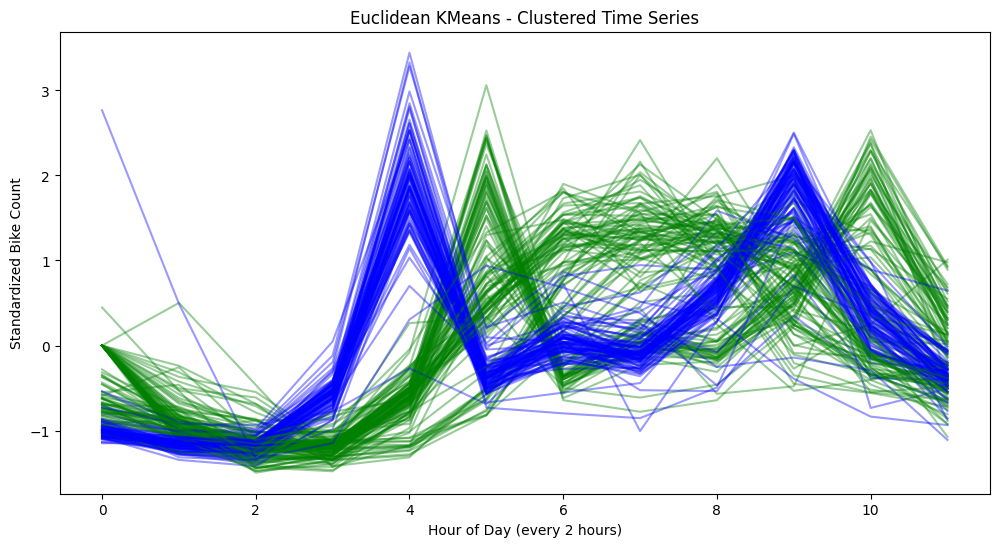

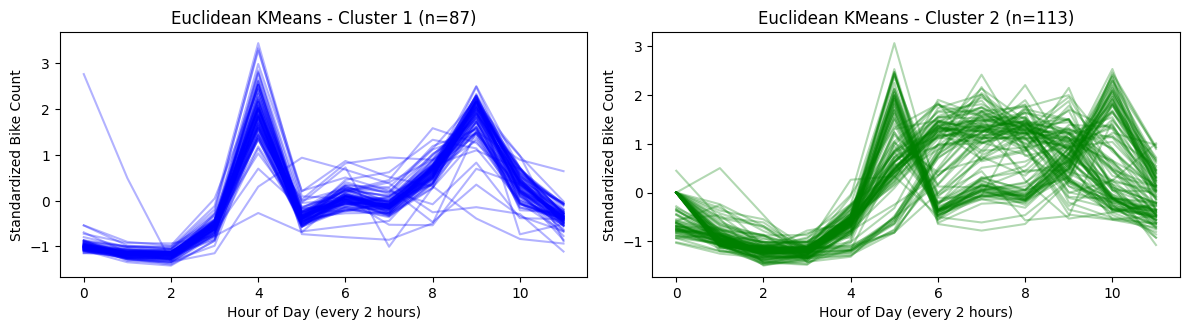

Silhouette Score: 0.40745903215680174 for K-Means with euclidean
Davies-Bouldin Score: 1.0362856898083588 for K-Means with euclidean

Running KMeans with DTW KMeans...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


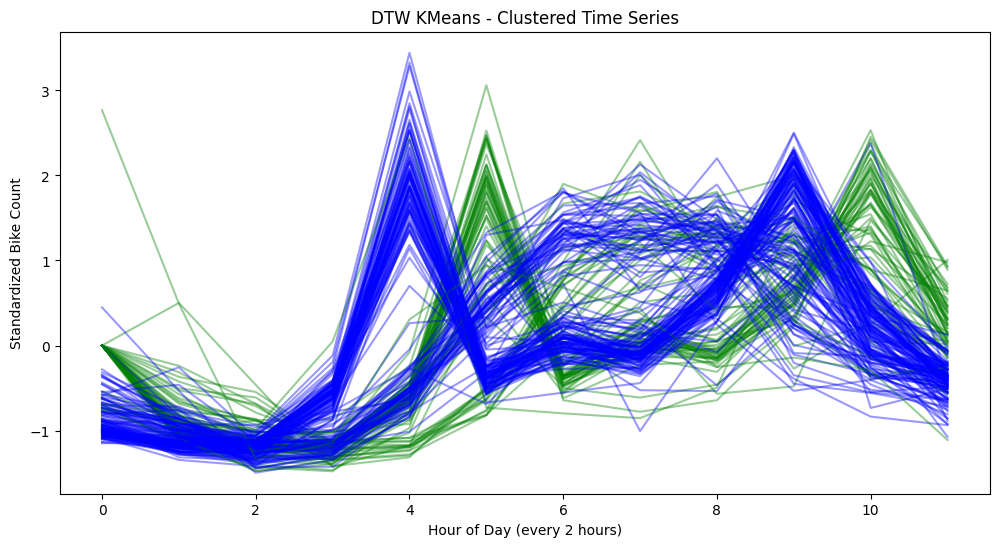

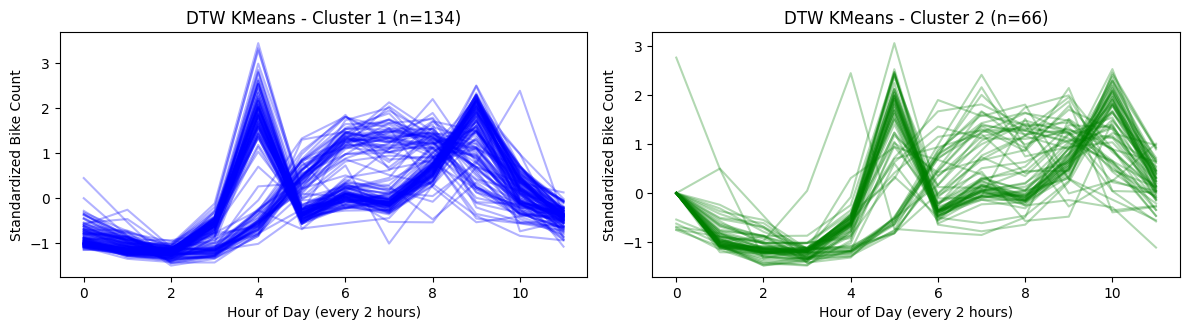

Silhouette Score: 0.3325340445298376 for K-Means with dtw
Davies-Bouldin Score: 1.3854049613363117 for K-Means with dtw


In [6]:
# Parameters
n_clusters = 2
colors = ["blue", "green", "red", "purple", "orange"]

# Clustering and plotting function
def run_kmeans(metric, title, metric_params=None):
    print(f"\nRunning KMeans with {title}...")
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric,
                              metric_params=metric_params,
                              random_state=42, n_init=10)
    labels = model.fit_predict(polar_ts)

    # Plot all series colored by cluster
    plt.figure(figsize=(12, 6))
    for i, series in enumerate(data_tslearn):
        plt.plot(series.ravel(), color=colors[labels[i]], alpha=0.4)
    plt.title(f"{title} - Clustered Time Series")
    plt.xlabel("Hour of Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plt.show()

    # Plot cluster-wise breakdown
    plt.figure(figsize=(12, 6))
    for i in range(n_clusters):
        cluster_data = data_tslearn[labels == i]
        plt.subplot(2, 2, i + 1)
        for series in cluster_data:
            plt.plot(series.ravel(), color=colors[i], alpha=0.3)
        plt.title(f"{title} - Cluster {i+1} (n={len(cluster_data)})")
        plt.xlabel("Hour of Day (every 2 hours)")
        plt.ylabel("Standardized Bike Count")
    plt.tight_layout()
    plt.show()

    # Plot cluster means
    # plt.figure(figsize=(10, 6))
    # for i in range(n_clusters):
    #     mean_pattern = data_tslearn[labels == i].mean(axis=0)
    #     plt.plot(mean_pattern.ravel(), label=f"Cluster {i+1}", color=colors[i])
    # plt.title(f"{title} - Average Pattern per Cluster")
    # plt.xlabel("Hour of Day (every 2 hours)")
    # plt.ylabel("Standardized Bike Count")
    # plt.legend()
    # plt.show()

    # Print mean per cluster
    cluster_means = [np.mean(data_tslearn[labels == i]) for i in range(n_clusters)]
    # print(f"{title} - Average standardized rentals per cluster:")
    # for i, m in enumerate(cluster_means):
    #     print(f"  Cluster {i+1}: {m:.2f}")

    silhoutte_score = silhouette_score(polar_scaled, labels)
    print(f"Silhouette Score: {silhoutte_score} for K-Means with {metric}")
    db_score = davies_bouldin_score(polar_scaled, labels)
    print(f"Davies-Bouldin Score: {db_score} for K-Means with {metric}")

# === Run all three clustering methods ===
run_kmeans(metric="euclidean", title="Euclidean KMeans")

run_kmeans(metric="dtw", title="DTW KMeans")

# run_kmeans(metric="softdtw", title="Soft-DTW KMeans", metric_params={"gamma": 0.01})


<ipython-input-7-4e357833dcb2>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_euclidean = linkage(euclidean_dist, method='ward')


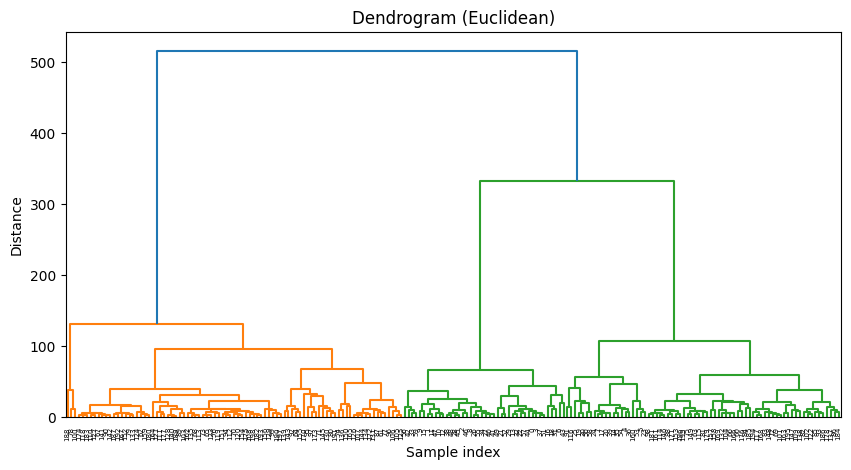

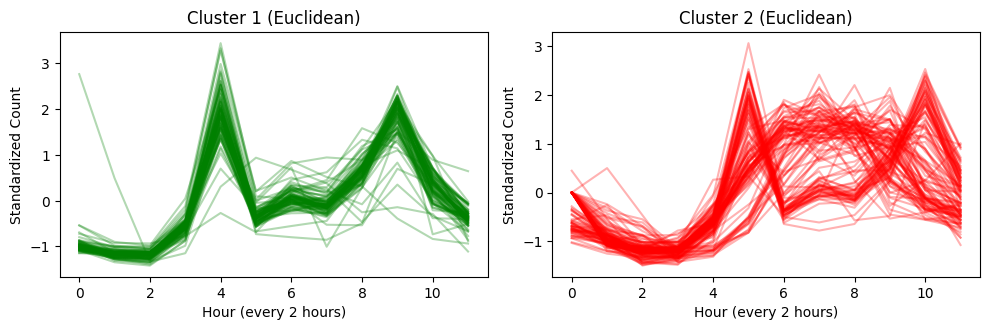

Silhouette Score: 0.40745903215680174 for Hierarchical with Euclidean
Davies-Bouldin Score: 1.0362856898083588 for Hierarchical with Euclidean


In [7]:
# Compute Euclidean distance matrix on 2D feature array
euclidean_dist = pairwise_distances(polar_scaled, metric='euclidean')

# Linkage for hierarchical clustering
Z_euclidean = linkage(euclidean_dist, method='ward')

# Dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z_euclidean)
plt.title("Dendrogram (Euclidean)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Assign cluster labels
n_clusters = 2
labels_euclidean = fcluster(Z_euclidean, n_clusters, criterion='maxclust')

# Plot clusters (on original time series)
colors = ["blue", "green", "red", "orange", "purple", "black"]
plt.figure(figsize=(10, 3 * n_clusters))
for i in range(1, n_clusters + 1):
    plt.subplot(n_clusters, 2, i)
    for ts in shifted_data[labels_euclidean == i]:
        plt.plot(ts, color=colors[i % len(colors)], alpha=0.3)
    plt.title(f"Cluster {i} (Euclidean)")
    plt.xlabel("Hour (every 2 hours)")
    plt.ylabel("Standardized Count")
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_euclidean)
print(f"Silhouette Score: {silhoutte_score} for Hierarchical with Euclidean")
db_score = davies_bouldin_score(polar_scaled, labels_euclidean)
print(f"Davies-Bouldin Score: {db_score} for Hierarchical with Euclidean")

<ipython-input-8-fb59b037b910>:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_dtw = linkage(dtw_dist, method='average')


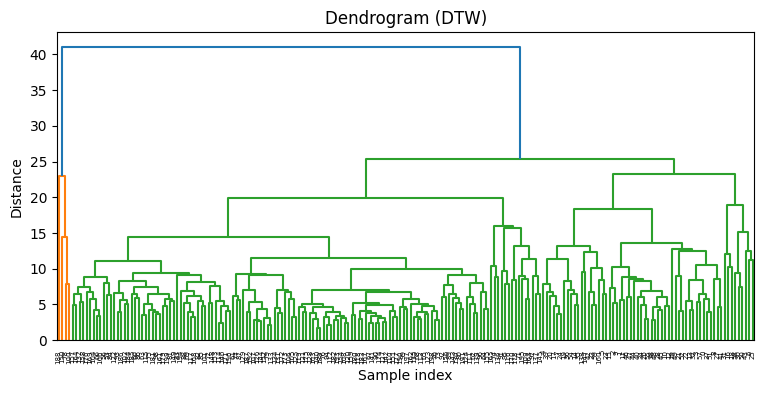

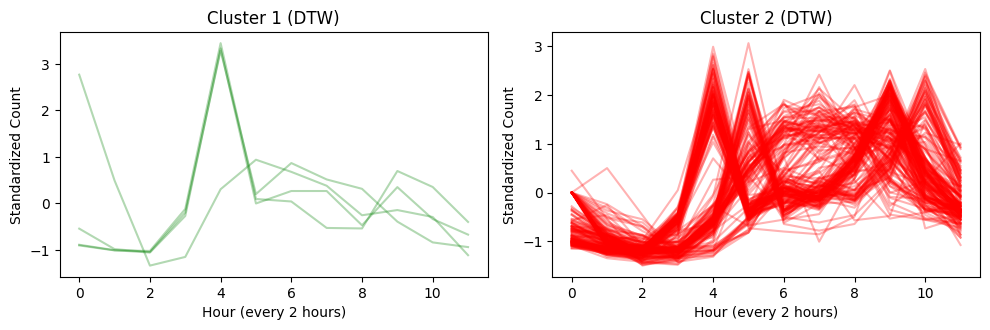

Silhouette Score: 0.28475763584964836 for Hierarchical with DTW
Davies-Bouldin Score: 1.442835810766177 for Hierarchical with DTW


In [8]:
# Compute DTW distance matrix
dtw_dist = cdist_dtw(polar_ts)

# Linkage (average is common for precomputed distances)
Z_dtw = linkage(dtw_dist, method='average')

# Plot dendrogram
plt.figure(figsize=(9, 4))
dendrogram(Z_dtw)
plt.title("Dendrogram (DTW)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

# Assign cluster labels
n_clusters_dtw = 2
labels_dtw = fcluster(Z_dtw, n_clusters_dtw, criterion='maxclust')

# Plot each cluster
plt.figure(figsize=(10, 3 * n_clusters_dtw))
for i in range(1, n_clusters_dtw + 1):
    plt.subplot(n_clusters_dtw, 2, i)
    for ts in shifted_data[labels_dtw == i]:
        plt.plot(ts, color=colors[i % len(colors)], alpha=0.3)
    plt.title(f"Cluster {i} (DTW)")
    plt.xlabel("Hour (every 2 hours)")
    plt.ylabel("Standardized Count")
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_dtw)
print(f"Silhouette Score: {silhoutte_score} for Hierarchical with DTW")
db_score = davies_bouldin_score(polar_scaled, labels_dtw)
print(f"Davies-Bouldin Score: {db_score} for Hierarchical with DTW")

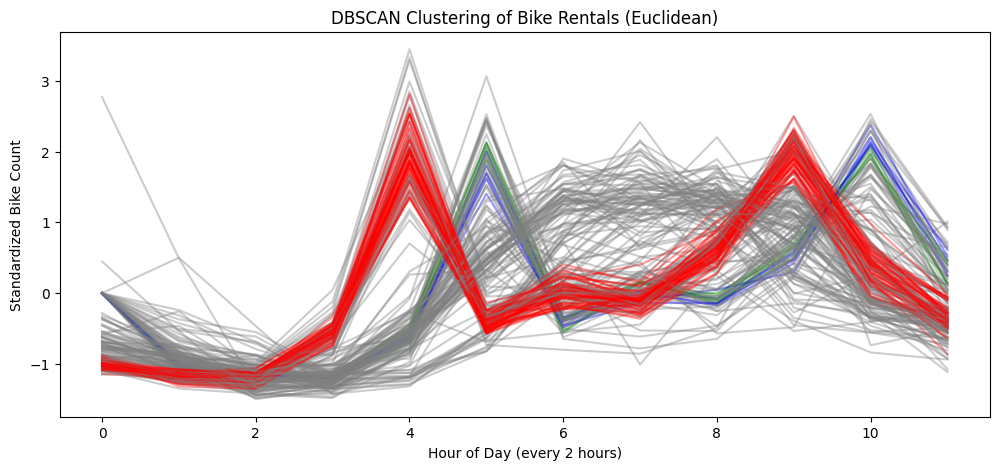

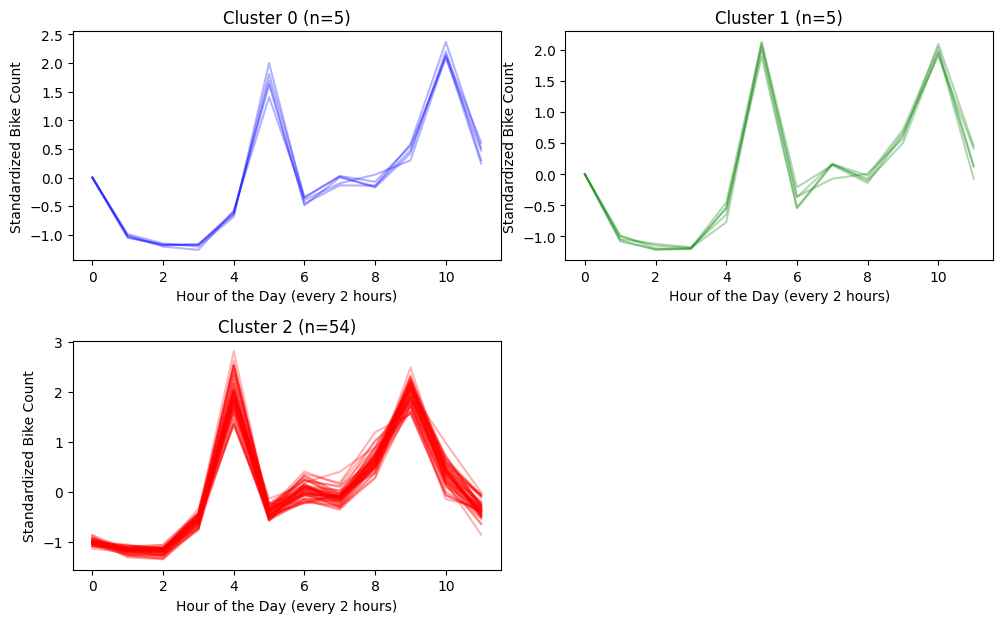

Silhouette Score: 0.08018532678879838 for DBSCAN with Euclidean
Davies-Bouldin Score: 1.1379193949607587 for DBSCAN with Euclidean
DBSCAN (Euclidean) Cluster Sizes (label - count):
  Cluster -1: 136 time series
  Cluster 0: 5 time series
  Cluster 1: 5 time series
  Cluster 2: 54 time series


In [9]:
# Compute Euclidean distance matrix
euclidean_dist_matrix = pairwise_distances(polar_scaled, metric='euclidean')

# Apply DBSCAN clustering with Euclidean distance
db_euclidean = DBSCAN(eps=1.25, min_samples=5, metric='precomputed')
labels_euclidean = db_euclidean.fit_predict(euclidean_dist_matrix)

# Define plot colors
colors = ["blue", "green", "red", "purple", "orange", "black"]
unique_labels_euclidean = np.unique(labels_euclidean)

# Plot all series colored by cluster
plt.figure(figsize=(12, 5))
for i, series in enumerate(shifted_data):
    label = labels_euclidean[i]
    color = "gray" if label == -1 else colors[label % len(colors)]
    plt.plot(series, color=color, alpha=0.4)
plt.title("DBSCAN Clustering of Bike Rentals (Euclidean)")
plt.xlabel("Hour of Day (every 2 hours)")
plt.ylabel("Standardized Bike Count")
plt.show()

# Plot each cluster separately
n_clusters = len([l for l in unique_labels_euclidean if l != -1])
plt.figure(figsize=(10, 3 * n_clusters))
plot_idx = 1
for label in unique_labels_euclidean:
    if label == -1:
        continue
    cluster_data = shifted_data[labels_euclidean == label]
    plt.subplot(n_clusters, 2, plot_idx)
    for series in cluster_data:
        plt.plot(series.ravel(), color=colors[label % len(colors)], alpha=0.3)
    plt.title(f"Cluster {label} (n={len(cluster_data)})")
    plt.xlabel("Hour of the Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plot_idx += 1
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_euclidean)
print(f"Silhouette Score: {silhoutte_score} for DBSCAN with Euclidean")
db_score = davies_bouldin_score(polar_scaled, labels_euclidean)
print(f"Davies-Bouldin Score: {db_score} for DBSCAN with Euclidean")

# Summary
print("DBSCAN (Euclidean) Cluster Sizes (label - count):")
for label in unique_labels_euclidean:
    print(f"  Cluster {label}: {(labels_euclidean == label).sum()} time series")

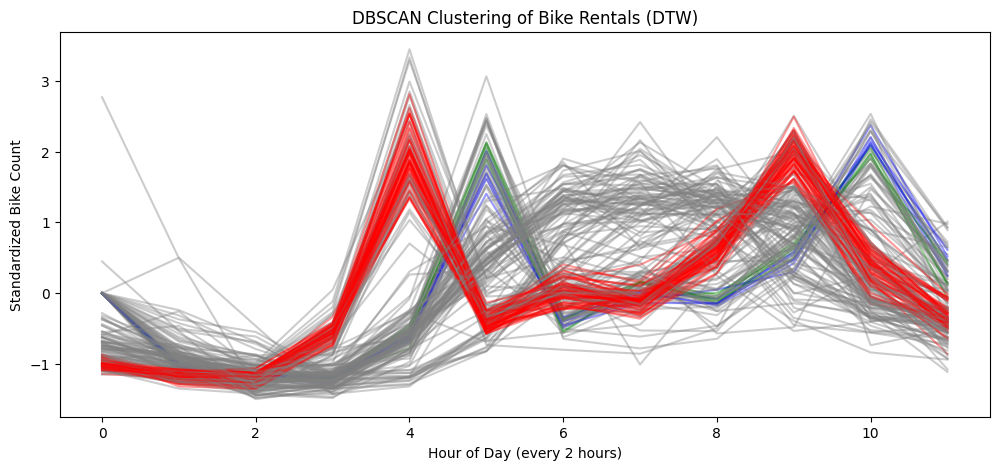

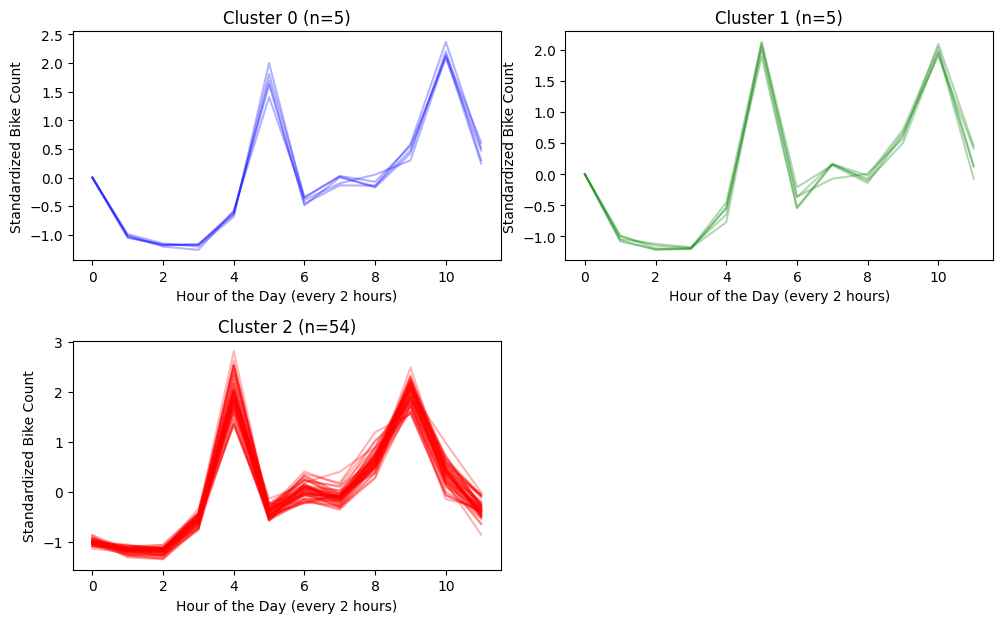

Silhouette Score: 0.19401666352494648 for DBSCAN with DTW
Davies-Bouldin Score: 3.2246216091276487 for DBSCAN with DTW


In [10]:
# Apply DBSCAN clustering
eps = 1.25
min_samples = 5
db_model = DBSCAN(metric="precomputed", eps=eps, min_samples=min_samples)
cluster_labels = db_model.fit_predict(dtw_matrix)

# Plot time series by cluster
unique_clusters = np.unique(cluster_labels)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']


# Plot all series colored by cluster
plt.figure(figsize=(12, 5))
for i, series in enumerate(shifted_data):
    label = labels_euclidean[i]
    color = "gray" if label == -1 else colors[label % len(colors)]
    plt.plot(series, color=color, alpha=0.4)
plt.title("DBSCAN Clustering of Bike Rentals (DTW)")
plt.xlabel("Hour of Day (every 2 hours)")
plt.ylabel("Standardized Bike Count")
plt.show()

# Plot each cluster separately
n_clusters = len([l for l in unique_labels_euclidean if l != -1])
plt.figure(figsize=(10, 3 * n_clusters))
plot_idx = 1
for label in unique_labels_euclidean:
    if label == -1:
        continue
    cluster_data = shifted_data[labels_euclidean == label]
    plt.subplot(n_clusters, 2, plot_idx)
    for series in cluster_data:
        plt.plot(series.ravel(), color=colors[label % len(colors)], alpha=0.3)
    plt.title(f"Cluster {label} (n={len(cluster_data)})")
    plt.xlabel("Hour of the Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plot_idx += 1
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, cluster_labels)
print(f"Silhouette Score: {silhoutte_score} for DBSCAN with DTW")
db_score = davies_bouldin_score(polar_scaled, cluster_labels)
print(f"Davies-Bouldin Score: {db_score} for DBSCAN with DTW")

# print("Cluster assignments:", cluster_labels)


In [ ]:
# # Remove noise points (-1) for silhouette evaluation
# mask = cluster_labels != -1
# filtered_dist = dtw_matrix[mask][:, mask]
# filtered_labels = cluster_labels[mask]

# # Check if enough clusters exist
# if len(np.unique(filtered_labels)) >= 2:
#     sil_score = silhouette_score(filtered_dist, filtered_labels, metric='precomputed')
#     print(f"Silhouette Score (DBSCAN + DTW): {sil_score:.4f}")
# else:
#     print("Not enough clusters for Silhouette Score (need at least 2, excluding noise).")

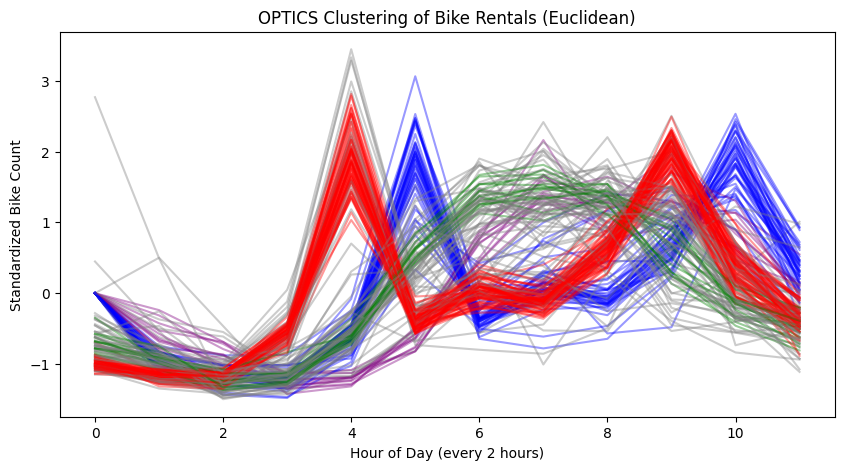

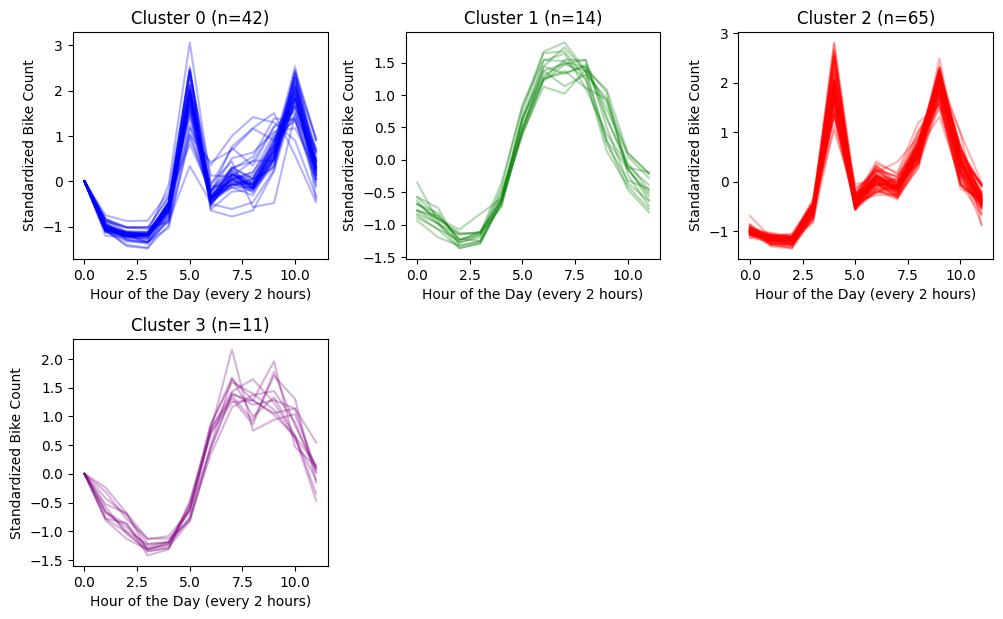

Silhouette Score: 0.25447967649257114 for OPTICS with Euclidean
Davies-Bouldin Score: 1.705829001232863 for OPTICS with Euclidean
OPTICS (Euclidean) Cluster Sizes:
  Cluster -1: 68 time series
  Cluster 0: 42 time series
  Cluster 1: 14 time series
  Cluster 2: 65 time series
  Cluster 3: 11 time series


In [11]:
# Euclidean Distance Matrix
euclidean_dist_matrix = pairwise_distances(polar_scaled, metric='euclidean')

# OPTICS Clustering
optics_euclidean = OPTICS(metric='precomputed', min_samples=10, xi=0.05)
labels_optics_euclidean = optics_euclidean.fit_predict(euclidean_dist_matrix)

# Plotting Results
colors = ["blue", "green", "red", "purple", "orange", "black"]
unique_labels = np.unique(labels_optics_euclidean)

# Plot all series colored by cluster
plt.figure(figsize=(10, 5))
for i, series in enumerate(shifted_data):
    label = labels_optics_euclidean[i]
    color = "gray" if label == -1 else colors[label % len(colors)]
    plt.plot(series, color=color, alpha=0.4)
plt.title("OPTICS Clustering of Bike Rentals (Euclidean)")
plt.xlabel("Hour of Day (every 2 hours)")
plt.ylabel("Standardized Bike Count")
plt.show()

# Plot each cluster separately
n_clusters = len([l for l in unique_labels if l != -1])
plt.figure(figsize=(10, 3 * n_clusters))
plot_idx = 1
for label in unique_labels:
    if label == -1:
        continue
    cluster_data = shifted_data[labels_optics_euclidean == label]
    plt.subplot(n_clusters, 3, plot_idx)
    for series in cluster_data:
        plt.plot(series.ravel(), color=colors[label % len(colors)], alpha=0.3)
    plt.title(f"Cluster {label} (n={len(cluster_data)})")
    plt.xlabel("Hour of the Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plot_idx += 1
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_optics_euclidean)
print(f"Silhouette Score: {silhoutte_score} for OPTICS with Euclidean")
db_score = davies_bouldin_score(polar_scaled, labels_optics_euclidean)
print(f"Davies-Bouldin Score: {db_score} for OPTICS with Euclidean")

# Summary
print("OPTICS (Euclidean) Cluster Sizes:")
for label in unique_labels:
    print(f"  Cluster {label}: {(labels_optics_euclidean == label).sum()} time series")


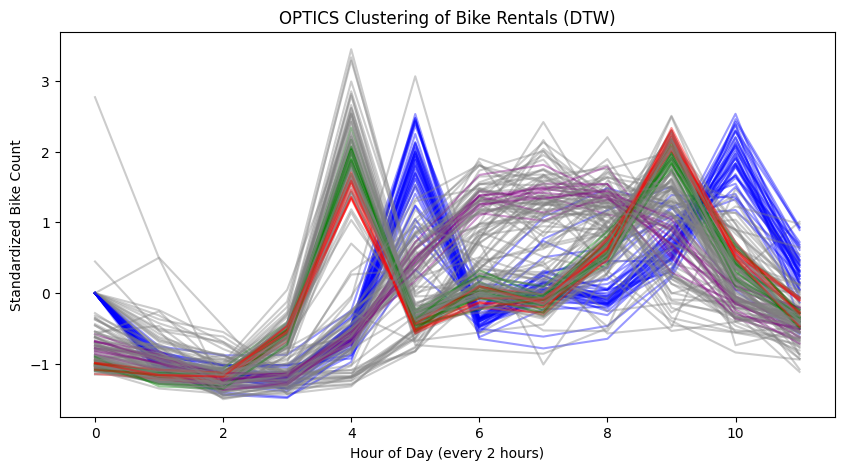

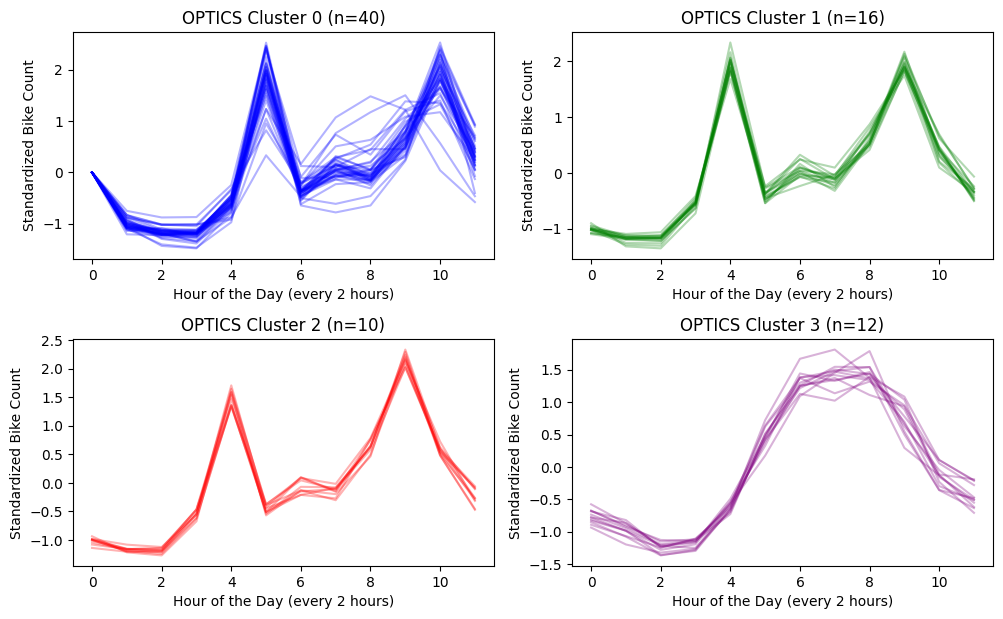

Silhouette Score: -0.10538081332032802 for OPTICS with DTW
Davies-Bouldin Score: 1.5892637013405855 for OPTICS with DTW


In [12]:
# Compute DTW distance matrix
dtw_dist_matrix = cdist_dtw(polar_ts)

# OPTICS with DTW
optics_dtw = OPTICS(min_samples=10, metric='precomputed', cluster_method='xi', xi=0.001)
labels_optics_dtw = optics_dtw.fit_predict(dtw_dist_matrix)

# Unique labels
unique_labels_optics_dtw = np.unique(labels_optics_dtw)

# Plot all series colored by cluster
plt.figure(figsize=(10, 5))
for i, series in enumerate(shifted_data):
    label = labels_optics_dtw[i]
    color = "gray" if label == -1 else colors[label % len(colors)]
    plt.plot(series, color=color, alpha=0.4)
plt.title("OPTICS Clustering of Bike Rentals (DTW)")
plt.xlabel("Hour of Day (every 2 hours)")
plt.ylabel("Standardized Bike Count")
plt.show()

# Plot each cluster separately
n_clusters = len([l for l in unique_labels_optics_dtw if l != -1])
plt.figure(figsize=(10, 3 * n_clusters))
plot_idx = 1
for label in unique_labels_optics_dtw:
    if label == -1:
        continue
    cluster_data = shifted_data[labels_optics_dtw == label]
    plt.subplot(n_clusters, 2, plot_idx)
    for series in cluster_data:
        plt.plot(series.ravel(), color=colors[label % len(colors)], alpha=0.3)
    plt.title(f"OPTICS Cluster {label} (n={len(cluster_data)})")
    plt.xlabel("Hour of the Day (every 2 hours)")
    plt.ylabel("Standardized Bike Count")
    plot_idx += 1
plt.tight_layout()
plt.show()

silhoutte_score = silhouette_score(polar_scaled, labels_optics_dtw)
print(f"Silhouette Score: {silhoutte_score} for OPTICS with DTW")
db_score = davies_bouldin_score(polar_scaled, labels_optics_dtw)
print(f"Davies-Bouldin Score: {db_score} for OPTICS with DTW")